In [54]:
import pandas as pd
import numpy as np
from DynamicFactor import DynamicFactorModel
from ForecastingwithDFM import ForecastingWithDFM
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pykalman import KalmanFilter


In [33]:
# Lecture du fichier *.txt
data = pd.read_csv('fredmq.txt', sep=',').set_index(keys='Date')
# Récupération des types de transformations dans un dictionnaire
transformations = dict(data.loc['Transform']) 
# Abandon de la ligne des transformations
data.drop(labels='Transform', inplace=True)
# Ajustement de l'indice du DataFrame au format datetime
data.index = pd.to_datetime(arg=data.index)
# Abandon des colonnes ayant un nombre de NaN's >= 30
data.dropna(thresh=len(data) - 30, axis=1, inplace=True)
# Abandon des NaN's restants
data.dropna(axis=0, inplace=True)

In [34]:
# Création du DataFrame stockant les séries transformées
transformed_data = pd.DataFrame()
# Transformation des séries selon les codes fournis par McCracken et Ng
for col in data.columns:
    # Récupération du code de transformation
    code = transformations[col]
    # Récupération de la série individuelle
    subset = data[col]
    # Application des transformées selon le code correspondant
    if code == 1:
        # Aucune transformation à appliquer
        temp = subset
    elif code == 2:
        # Différence première
        temp = subset.diff(periods=1)
    elif code == 3:
        # Différence seconde 
        temp = subset.diff(periods=1).diff(periods=1)
    elif code == 4:
        # Transformée en log
        temp = np.log(subset)
    elif code == 5:
        # Différence première du log
        temp = np.log(subset).diff(periods=1)
    elif code == 6:
        # Différence seconde du log 
        temp = np.log(subset).diff(periods=1).diff(periods=1)
    elif code == 7:
        # Différence première de la variation relative
        temp = subset.pct_change().diff(periods=1)
    # Aggrégation des séries transformées
    transformed_data = pd.concat([transformed_data, temp], axis=1)
# Abandon des NaN's causées par les différences premières et secondes
transformed_data.dropna(axis=0, inplace=True)

In [35]:
# Calcul de la médiane des séries
medians = transformed_data.median(axis=0)
# DataFrame contenant les médianes des séries en chaque point
mdf =  transformed_data * 0 + medians
# Calcul de la distance entre les observations et les médianes
z = abs(transformed_data - mdf)
# Calcul de la gamme interquartile des séries
irq = transformed_data.quantile(q=.75) - transformed_data.quantile(q=.25)
# DataFrame contenant les gammes interquartiles des séries en chaque point
irqdf = transformed_data * 0 + irq
# Détermination des outliers (x est un outlier si abs(x - mediane) > 10 * gamme interquartile)
outliers = z > 10 * irqdf
# Abandon des observations considérées comme outliers
mapping = transformed_data[outliers == False].dropna(axis=0)

In [39]:
# Sélection de la période d'estimation
estimation_sample = mapping.loc[(mapping.index >= pd.to_datetime('1983-01-01')) & (mapping.index <= pd.to_datetime('2016-12-01'))]
# Sélection de la période de prévision
forecast_sample = mapping.loc[mapping.index >= pd.to_datetime('2017-01-01')]

In [40]:
# Standardisation des données d'estimation en échantillon
estimation_sample_std = (estimation_sample - estimation_sample.mean(axis=0)) / estimation_sample.std(axis=0)
# Standardisation des données d'estimation hors échantillon
forecast_sample_std = (forecast_sample - forecast_sample.mean(axis=0)) / forecast_sample.std(axis=0)

In [41]:
estimation_sample_std

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1983-03-01,0.449066,0.248101,1.721643,1.694292,2.098154,1.150470,1.013769,0.550512,0.393527,0.607086,...,0.642718,-1.742659,-2.142131,-1.346560,-2.392695,1.592923,1.216903,1.956168,0.784695,-0.043435
1983-04-01,-0.300639,-0.154651,0.770879,-0.326263,-0.133306,1.937413,1.933051,1.660330,2.617044,1.040198,...,0.992028,1.589171,0.723032,0.008005,0.694548,2.141377,-0.649699,-1.244423,0.005713,-0.170126
1983-05-01,0.502507,0.357311,0.726766,1.547905,1.180754,0.751510,0.681358,0.561311,0.287061,0.869108,...,-0.208190,-1.187006,0.007325,-0.670171,0.349950,1.070586,-0.115029,0.179001,-0.198108,-0.256890
1983-06-01,-0.194698,0.044041,1.528472,2.749613,1.767617,0.714177,0.541458,0.280850,0.298652,0.784570,...,-0.686630,2.249341,0.363829,0.957451,-0.331315,-0.313608,0.574007,0.976976,0.056520,-0.128748
1983-07-01,0.076724,0.575678,0.913518,-0.379462,0.159464,2.371864,2.133012,1.775402,1.641782,1.104806,...,0.238171,1.551269,0.716502,-0.127751,1.023412,0.130379,-0.499466,-0.853112,-2.157510,0.501987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,-0.241775,-0.305044,-0.331446,0.603267,-0.295028,-0.594307,-0.370667,-0.088367,0.111242,-0.355952,...,1.042795,-0.283464,0.153278,0.008033,0.440231,-0.078556,0.851026,0.740891,-0.488817,-1.121881
2016-09-01,-0.010275,0.084557,0.016563,-0.143813,0.229042,-0.623833,-0.520086,-0.632517,-0.476555,0.027381,...,0.559102,-0.374126,0.298204,0.302052,-0.561487,0.339314,-0.293422,-0.342653,0.425401,-0.846650
2016-10-01,-0.129021,-0.218991,-0.666820,-0.166519,-0.197105,-0.298237,-0.631337,-0.503694,-0.901320,0.165784,...,-0.040651,0.368277,-0.139073,0.007023,0.154018,-1.070997,-0.640060,-0.602281,-0.275078,-0.780748
2016-11-01,0.046438,0.186593,-0.198498,-0.268428,-0.421430,-1.188113,-1.180510,-1.319876,-1.662740,-1.056193,...,-0.814105,-0.002943,-0.138302,-0.343980,-0.131641,1.697390,0.010194,0.101163,-0.908454,-0.717985


In [42]:
forecast_sample_std

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
2017-01-01 00:00:00,0.159473,-0.027850,-0.482504,0.293338,1.050563,-0.654781,-0.961048,-1.000831,-1.417394,0.099092,...,0.739912,0.529883,0.685665,0.771453,-0.750423,0.024778,0.103790,-0.505347,0.781975,-0.792750
2017-02-01 00:00:00,0.143837,0.078974,-0.500487,-0.551101,-0.443260,-0.911217,-1.136257,-1.173508,-1.555818,-0.245867,...,-1.377432,-0.456501,-1.080368,-1.307261,0.150471,-0.788235,-0.677951,-0.766464,0.496299,-0.826104
2017-03-01 00:00:00,0.363682,0.180973,0.646752,-0.647951,-0.648163,0.994807,0.656432,0.763719,0.699415,-0.739926,...,0.101313,-1.914510,1.124860,1.014541,0.689178,0.122339,1.669057,1.753059,-0.451840,-0.762186
2017-04-01 00:00:00,-0.208695,-0.076502,-0.560575,-0.923816,0.098435,1.566648,1.690225,1.706933,0.895275,1.057983,...,-0.167392,2.681195,-0.931462,-0.999894,0.147348,-0.040263,-1.523651,-1.358994,-0.705275,-0.486649
2017-05-01 00:00:00,1.179885,0.987874,-0.471683,0.535640,-1.090478,0.013732,0.281578,0.421296,0.540092,-0.598834,...,-1.186924,-1.082075,1.411597,1.438013,-0.211172,-0.040263,1.726047,2.092504,0.567119,-0.974502
2017-06-01 00:00:00,-0.449437,-0.623185,0.282497,0.396104,0.121379,0.152754,-0.277934,-0.320488,-0.509630,-0.351183,...,1.169249,-0.006133,-0.784397,-0.332369,-0.209870,-0.755715,-0.779692,0.476612,-1.017779,-1.027840
2017-07-01 00:00:00,0.268867,0.042928,0.082130,0.533194,-0.420581,-0.641378,-0.419739,-0.403517,-0.425790,-1.443965,...,0.255439,-0.801180,0.382650,-0.267723,0.679986,-0.593112,0.369355,-1.347048,0.460626,-1.068347
2017-08-01 00:00:00,-0.201701,-0.396978,-0.623095,0.829904,-0.168518,-1.022847,-0.295059,-0.032928,-0.202842,0.367096,...,0.996773,0.696529,-0.488528,0.034663,-1.097737,1.032913,-0.176109,-0.012810,-0.025754,-0.732996
2017-09-01 00:00:00,0.075316,-0.021038,0.948878,0.691329,2.295497,-0.015637,0.437084,0.354567,-0.088188,0.522025,...,1.267144,0.133379,0.523839,0.451276,1.031888,-0.625633,0.582635,0.310167,0.272918,-1.017061
2017-10-01 00:00:00,0.455601,0.261315,-0.380194,0.850579,-0.232695,2.090325,1.126881,0.981685,0.900457,0.289033,...,-2.930276,0.225165,-1.636410,-1.934243,-0.387155,1.748365,-0.319081,-0.182637,-0.010572,-1.100147


# Mise en place des paramètres

# Mise en place du Dynamic Factor Model

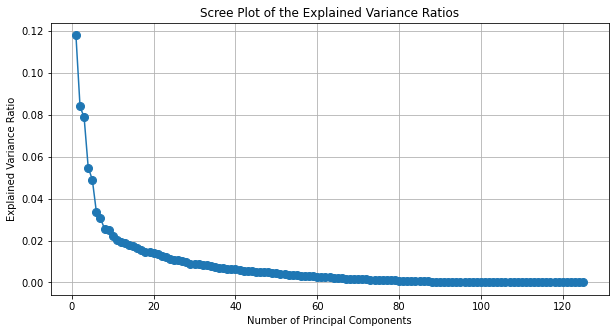

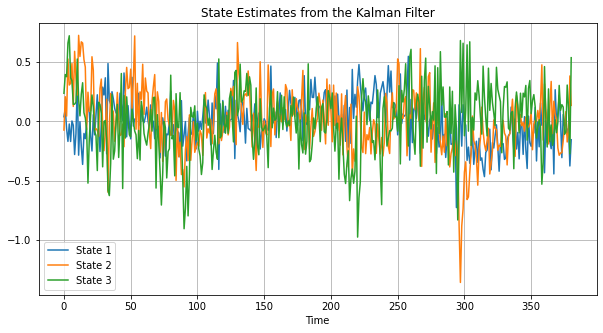

In [55]:
# PCA analysis
pca = PCA()
pca.fit(estimation_sample_std)
explained_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

# Plotting PCA results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, 'o-', markersize=8)
plt.title('Scree Plot of the Explained Variance Ratios')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Using PyKalman for the Kalman Filter
# Set up some dummy values for demonstration
n_timesteps = data.shape[0]  # Number of time steps
n_dim_state = 3  # Dimensionality of the state
n_dim_obs = data.shape[1]  # Dimensionality of the observations

# Initialize the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.eye(n_dim_state),
    observation_matrices=np.random.rand(n_dim_obs, n_dim_state),
    transition_covariance=0.01 * np.eye(n_dim_state),
    observation_covariance=0.01 * np.eye(n_dim_obs),
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=0.1 * np.eye(n_dim_state)
)

# Use the Kalman Filter to estimate states
state_means, state_covariances = kf.smooth(estimation_sample_std)

# Example of plotting state estimates
plt.figure(figsize=(10, 5))
for i in range(n_dim_state):
    plt.plot(state_means[:, i], label=f'State {i+1}')
plt.title('State Estimates from the Kalman Filter')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

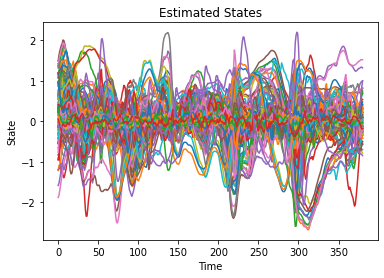

In [56]:

n_timesteps, n_features = estimation_sample_std.shape

# Initialize the Kalman Filter with simplistic assumptions
kf = KalmanFilter(
    transition_matrices=np.eye(n_features),  # Simplistic identity matrix for demonstration
    observation_matrices=np.eye(n_features),  # Direct observation of all factors
    initial_state_mean=np.zeros(n_features),
    initial_state_covariance=np.eye(n_features),
    transition_covariance=np.eye(n_features) * 0.01,
    observation_covariance=np.eye(n_features) * 0.1
)

# Estimate the states
state_means, state_covariances = kf.smooth(estimation_sample_std)

# Plot the estimated states
plt.plot(state_means)
plt.title('Estimated States')
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

## 1.Extraction des charges factorielles et des variances idiosyncratiques

In [65]:
from sklearn.decomposition import PCA
# Conversion du DataFrame en numpy array pour utilisation dans les modèles statistiques
data_matrix = estimation_sample_std.values  # Convertit le DataFrame en numpy array

# Configuration de PCA pour le nombre de composants que vous souhaitez (e.g., r = 1, 3, 7)
pca_r1 = PCA(n_components=1)
pca_r3 = PCA(n_components=3)
pca_r7 = PCA(n_components=7)

# Ajustement de PCA sur les données standardisées
pca_r1.fit(data_matrix)
pca_r3.fit(data_matrix)
pca_r7.fit(data_matrix)

# Extraction des charges factorielles
loadings_r1 = pca_r1.components_
loadings_r3 = pca_r3.components_
loadings_r7 = pca_r7.components_

# Calcul des variances idiosyncratiques pour r = 1
variances_r1 = np.sum(pca_r1.explained_variance_ratio_)
idiosyncratic_var_r1 = 1 - variances_r1


## 2. Paramètres autoregressifs des facteurs
Pour extraire les paramètres autoregressifs via le filtre de Kalman, vous devez d'abord définir le modèle AR(p). Supposons que nous utilisons un modèle AR(1) :

In [66]:
# Utilisation de la première composante principale pour ajuster un modèle AR(1)
model_ar = AutoReg(pca_r1.transform(data_matrix)[:, 0], lags=1)  # Utilisez la première composante principale pour AR(1)
res_ar = model_ar.fit()
phi_1 = res_ar.params[1]  # Paramètre autoregressif


## 3. Erreur quadratique moyenne (MSE) des facteurs
Pour calculer le MSE des facteurs estimés :

In [67]:
# Calcul de MSE pour le premier facteur estimé via PCA pour simplifier l'exemple
predicted_factors = pca_r1.transform(data_matrix)  # Transforme les données selon le modèle PCA
mse_r1 = np.mean((data_matrix[:, 0] - predicted_factors[:, 0])**2)


## 4. Log-Vraisemblance
Pour le calcul de la log-vraisemblance :

In [68]:
# Définition du nombre de dimensions pour les observations (nombre de variables dans le DataFrame)
n_dim_obs = data_matrix.shape[1]

# Configuration et exécution du filtre de Kalman
kf = KalmanFilter(transition_matrices=np.array([[1]]),
                  observation_matrices=np.eye(n_dim_obs),
                  transition_covariance=np.array([[0.01]]),
                  observation_covariance=np.eye(n_dim_obs) * 1,
                  initial_state_mean=np.zeros(1),
                  initial_state_covariance=np.array([[1]]))

# Exécution de l'algorithme EM pour estimer les paramètres du filtre
kf = kf.em(data_matrix, n_iter=5)
log_likelihood = kf.loglikelihood(data_matrix)



ValueError: The shape of all parameters is not consistent.  Please re-check their values.

In [69]:
# Nombre de dimensions de l'état (nombre de facteurs que vous estimez)
n_dim_state = 1  # Exemple avec un seul facteur

# Nombre de dimensions d'observation (nombre de variables observées)
n_dim_obs = data_matrix.shape[1]

# Configuration du filtre de Kalman
kf = KalmanFilter(
    transition_matrices=np.eye(n_dim_state),  # Matrice d'identité de taille n_dim_state x n_dim_state
    observation_matrices=np.random.rand(n_dim_obs, n_dim_state),  # Matrice aléatoire de taille n_dim_obs x n_dim_state
    transition_covariance=np.eye(n_dim_state) * 0.01,  # Covariance des transitions
    observation_covariance=np.eye(n_dim_obs),  # Covariance des observations
    initial_state_mean=np.zeros(n_dim_state),  # Moyenne de l'état initial
    initial_state_covariance=np.eye(n_dim_state)  # Covariance de l'état initial
)

# Exécution de l'algorithme EM pour estimer les paramètres du filtre
kf = kf.em(data_matrix, n_iter=5)
log_likelihood = kf.loglikelihood(data_matrix)

In [72]:
# MultiIndex pour les colonnes
methods = ['TS-LS', 'ML-NO', 'ML-EM']
levels = [f'p = {p}' for p in [1, 3]]
columns = pd.MultiIndex.from_product([levels, methods], names=['Regime', 'Method'])

# Index pour les lignes
parameters = ['Σ λ_i^2', 'Σ σ_i^2', 'φ11', 'φ21', 'φ31', 'MSE (F̂1r)', 'log-Lik']
index = pd.MultiIndex.from_product([[1, 3, 7], parameters], names=['r', 'Parameter'])

# Création du DataFrame
df_results = pd.DataFrame(index=index, columns=columns)

# Remplissage des valeurs
# Remarque: vous devez calculer ou insérer les valeurs pour chaque configuration
# Exemple de remplissage pour r = 1, p = 1 (Vous devez ajuster ou calculer les valeurs pour tous les cas)
df_results.loc[(1, 'Σ λ_i^2'), ('p = 1', 'TS-LS')] = pca_r1.explained_variance_ratio_.sum()
df_results.loc[(1, 'Σ σ_i^2'), ('p = 1', 'TS-LS')] = idiosyncratic_var_r1
df_results.loc[(1, 'φ11'), ('p = 1', 'TS-LS')] = phi_1
df_results.loc[(1, 'MSE (F̂1r)'), ('p = 1', 'TS-LS')] = mse_r1
df_results.loc[(1, 'log-Lik'), ('p = 1', 'TS-LS')] = log_likelihood

# Exemple de remplissage pour d'autres valeurs de r et p
# Vous devrez répéter le calcul ou ajuster les indices pour r=3, r=7, et p=3
# Calculs pour r=3
explained_var_r3 = pca_r3.explained_variance_ratio_.sum()
idiosyncratic_var_r3 = 1 - explained_var_r3
phi_r3 = AutoReg(pca_r3.transform(data_matrix)[:, 0], lags=1).fit().params[1]  # Supposant modèle AR(1) pour simplifier
mse_r3 = np.mean((data_matrix[:, 0] - pca_r3.transform(data_matrix)[:, 0])**2)

# Calculs pour r=7
explained_var_r7 = pca_r7.explained_variance_ratio_.sum()
idiosyncratic_var_r7 = 1 - explained_var_r7
phi_r7 = AutoReg(pca_r7.transform(data_matrix)[:, 0], lags=1).fit().params[1]  # Supposant modèle AR(1) pour simplifier
mse_r7 = np.mean((data_matrix[:, 0] - pca_r7.transform(data_matrix)[:, 0])**2)

# Exemple de remplissage du DataFrame
df_results.loc[(3, 'Σ λ_i^2'), ('p = 1', 'TS-LS')] = explained_var_r3
df_results.loc[(3, 'Σ σ_i^2'), ('p = 1', 'TS-LS')] = idiosyncratic_var_r3
df_results.loc[(3, 'φ11'), ('p = 1', 'TS-LS')] = phi_r3
df_results.loc[(3, 'MSE (F̂1r)'), ('p = 1', 'TS-LS')] = mse_r3

df_results.loc[(7, 'Σ λ_i^2'), ('p = 1', 'TS-LS')] = explained_var_r7
df_results.loc[(7, 'Σ σ_i^2'), ('p = 1', 'TS-LS')] = idiosyncratic_var_r7
df_results.loc[(7, 'φ11'), ('p = 1', 'TS-LS')] = phi_r7
df_results.loc[(7, 'MSE (F̂1r)'), ('p = 1', 'TS-LS')] = mse_r7

# Affichage du DataFrame
print(df_results)

Regime               p = 1             p = 3            
Method               TS-LS ML-NO ML-EM TS-LS ML-NO ML-EM
r Parameter                                             
1 Σ λ_i^2         0.117959   NaN   NaN   NaN   NaN   NaN
  Σ σ_i^2         0.882041   NaN   NaN   NaN   NaN   NaN
  φ11             0.633332   NaN   NaN   NaN   NaN   NaN
  φ21                  NaN   NaN   NaN   NaN   NaN   NaN
  φ31                  NaN   NaN   NaN   NaN   NaN   NaN
  MSE (F̂1r)     18.093429   NaN   NaN   NaN   NaN   NaN
  log-Lik    -25353.981968   NaN   NaN   NaN   NaN   NaN
3 Σ λ_i^2         0.280731   NaN   NaN   NaN   NaN   NaN
  Σ σ_i^2         0.719269   NaN   NaN   NaN   NaN   NaN
  φ11             0.633332   NaN   NaN   NaN   NaN   NaN
  φ21                  NaN   NaN   NaN   NaN   NaN   NaN
  φ31                  NaN   NaN   NaN   NaN   NaN   NaN
  MSE (F̂1r)     18.093429   NaN   NaN   NaN   NaN   NaN
  log-Lik              NaN   NaN   NaN   NaN   NaN   NaN
7 Σ λ_i^2         0.448815   Na

In [76]:
# Chargement et préparation des données
data_matrix = estimation_sample_std.values  # exemple de vos données transformées

# Configuration de PCA pour différentes valeurs de r
pca = {r: PCA(n_components=r).fit(data_matrix) for r in [1, 3, 7]}

# Calculs pour chaque valeur de r
results = {}
for r, model in pca.items():
    scores = model.transform(data_matrix)
    explained_var = model.explained_variance_ratio_.sum()
    idiosyncratic_var = 1 - explained_var
    
    # Ajustement du modèle AR(1) sur la première composante principale
    if scores.shape[1] > 0:  # vérifier qu'il y a au moins une composante
        model_ar = AutoReg(scores[:, 0], lags=1).fit()
        phi_1 = model_ar.params[1]
        mse = np.mean((data_matrix[:, 0] - scores[:, 0])**2)
    else:
        phi_1 = np.nan
        mse = np.nan

    # Configuration du filtre de Kalman avec un état pour chaque composante principale
    kf = KalmanFilter(
        transition_matrices=np.eye(r),
        observation_matrices=np.random.rand(data_matrix.shape[1], r),
        transition_covariance=np.eye(r) * 0.01,
        observation_covariance=np.eye(data_matrix.shape[1]),
        initial_state_mean=np.zeros(r),
        initial_state_covariance=np.eye(r)
    )
    kf = kf.em(data_matrix, n_iter=5)
    log_likelihood = kf.loglikelihood(data_matrix)

    # Stockage des résultats
    results[r] = (explained_var, idiosyncratic_var, phi_1, mse, log_likelihood)

# Création d'un DataFrame pour afficher les résultats
df_results = pd.DataFrame(results, index=['Σ λ_i^2', 'Σ σ_i^2', 'φ11', 'MSE (F̂1r)', 'log-Lik']).T
print(df_results)

    Σ λ_i^2   Σ σ_i^2       φ11  MSE (F̂1r)       log-Lik
1  0.117959  0.882041  0.633332   18.093429 -25430.363591
3  0.280731  0.719269  0.633332   18.093429 -25956.564545
7  0.448815  0.551185  0.633332   18.093429 -27071.763125


In [ ]:
# Récupération de données près le 01/01/2021 pour une possible annexe

In [14]:
import requests
import pandas as pd

# Spécifiez les tickers des séries que vous souhaitez récupérer
tickers = estimation_sample_std.columns.to_list()
# Supprimer le 'x' à la fin de chaque terme
tickers_cleaned = [term.rstrip('x') for term in tickers]

# Base URL de l'API FRED
base_url = 'https://api.stlouisfed.org/fred/series/observations'

# Clé API FRED
api_key = 'c78f8ad50c3f014609882fc3a41d8246'

# Dictionnaire pour stocker les données
all_data = {}
ticker_empty=[]
# Récupérer les données pour chaque ticker
for ticker in tickers_cleaned:
    url = f'{base_url}?series_id={ticker}&api_key={api_key}&file_type=json&frequency=m'
    #url = f'{base_url}?series_id={ticker}&api_key={api_key}&file_type=json'
    response = requests.get(url)
    data = response.json()
    p
    # Vérifier si le ticker existe dans les données
    if 'observations' in data:
        # Filtrer les données pour la période spécifiée
        filtered_data = [obs for obs in data['observations'] if 'date' in obs and 'value' in obs and 'realtime_start' in obs and 'realtime_end' in obs and obs['date'] >= '2017-01-01' and obs['date'] <= '2024-04-01']
        all_data[ticker] = filtered_data
    else:
        #print(f"Le ticker {ticker} n'existe pas dans les données.")
        ticker_empty.append(ticker)
# Créer un DataFrame à partir des données
dfs = {}
for ticker, data in all_data.items():
    dfs[ticker] = pd.DataFrame(data)


# Convertir les données en DataFrames pour chaque indicateur
dfscleaned = []

for indicator, values in dfs.items():
    df = pd.DataFrame(values)
    if not df.empty:
        df.set_index('date', inplace=True)
        df.rename(columns={'value': indicator}, inplace=True)
        # Supprimer les colonnes 'realtime_start' et 'realtime_end'
        df.drop(columns=['realtime_start', 'realtime_end'], inplace=True)
        dfscleaned.append(df)
    else:
        ticker_empty.append(indicator)

# Fusionner les DataFrames en un seul
df_combined = pd.concat(dfscleaned, axis=1)

# Afficher le DataFrame combiné
#df_combined



In [16]:
df_combined

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENT,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,16383.236,13541.3,98.839,1365202.000,98.7987,99.1552,99.0330,100.3095,101.5192,99.9543,...,100.045,99.015,22.87,26.40,20.63,98.5,304911.01,735727.48,3321.8923,11.61
2017-02-01,16431.536,13589.2,98.892,1363025.000,98.4322,98.4654,98.0920,98.9026,101.1175,98.2521,...,99.999,99.231,22.86,26.33,20.64,96.3,302927.61,731024.65,3344.9762,11.53
2017-03-01,16491.77,13642.8,99.331,1360169.000,99.0663,98.9354,98.7285,99.5125,99.6555,99.4721,...,100.003,99.209,22.93,26.43,20.69,96.9,304015.25,731639.29,3359.2402,11.90
2017-04-01,16521.43,13682.6,99.364,1355381.000,100.0082,100.0831,100.1470,100.3026,102.0769,99.7842,...,99.912,99.534,22.94,26.37,20.75,97,302075.41,727865.34,3359.0723,13.14
2017-05-01,16626.085,13780.7,99.427,1360858.000,100.1286,100.3142,100.5119,100.7767,100.9060,100.7399,...,99.179,99.727,23.05,26.55,20.80,97.1,303306.64,730438.04,3372.0493,10.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,19265.016,15893.6,117.796,1523993.000,102.6149,100.8179,101.2544,101.7841,108.0061,100.0588,...,119.192,124.912,30.42,34.98,27.13,69.7,521938.91,921959.34,5085.0478,12.72
2024-01-01,19382.171,15935.5,117.425,1504096.000,101.811,100.3736,100.919,101.6965,105.3509,100.6426,...,118.755,125.799,30.57,35.30,27.21,79,524940.39,924448.27,5112.786,13.39
2024-02-01,19370.105,15913.7,117.991,1511532.000,102.2599,100.5583,100.7451,100.8224,107.4615,98.9903,...,119.537,126.13,30.67,35.23,27.35,76.9,527544.9,925641.71,5110.8945,13.98


In [71]:
print("les données non retrouvées")
ticker_empty

les données non retrouvées


['HWI',
 'HWIURATIO',
 'CLAIMS',
 'AMDMNO',
 'CONSPI',
 'S&P 500',
 'S&P div yield',
 'S&P PE ratio',
 'COMPAPFF',
 'UMCSENT',
 'DTCOLNVHFNM',
 'DTCTHFNM',
 'INVEST',
 'VIXCLS',
 'RETAIL',
 'CP3M',
 'OILPRICE']